# Data Profiling
# 0. Set up

In [1]:
# import libraries
%matplotlib inline
import pandas as pd
import seaborn as sns
from cryptography.fernet import Fernet
from thefuzz import process
import missingno as msno


# load data
df = pd.read_csv('input/dirty-loan-data.csv')
df.shape

(50100, 60)

In [2]:
df.head(5)

,Unnamed: 0,id_pk,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,next_pymnt_year,last_credit_pull_month,last_credit_pull_year,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,0,55978502,59640239,14400.0,14400.0,14400.0,36,5.61,50000.0,D,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,15278.0,15000.0
1,1,56141977,59803813,24550.0,24550.0,24550.0,36,2.29,50000.0,C,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,163368.0,41400.0
2,2,18935279,21167968,20000.0,20000.0,20000.0,60,6.29,50000.0,D,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,35408.0,28300.0
3,3,27580978,30084088,15000.0,15000.0,15000.0,36,-3.97,50000.0,A,...,NaN,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,146372.0,81600.0
4,4,4536779,5779043,16000.0,16000.0,15950.0,36,-1.10,50000.0,A,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,355820.0,45600.0


# 1. Create Data Profile

In [3]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title='Profiling Report: Dirty Loan Data', minimal=True)
profile.to_file(output_file='output/profile/dirty_profiling_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 1.1. Analyze Completeness
## 1.1.1. Missing Data
Missing data can be analyzed on a row or column level. We can start by looking at missing data on the row level. In specific, we want to identify rows where a large percentage of variables are missing. We can do this by calculating the percentage of missing values for each row.

In [4]:
# calculate percentage of missing values for each row
missing_values = df.isnull().mean(axis=1)

missing_values.sort_values(ascending=False).head(10)

5990     0.266667
23922    0.250000
25156    0.233333
34648    0.233333
31652    0.133333
17103    0.133333
28147    0.133333
4481     0.133333
19287    0.133333
5833     0.116667
dtype: float64

In [5]:
# show rows with more than 20% missing values
df[df.isnull().mean(axis=1) > 0.2]

,Unnamed: 0,id_pk,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,next_pymnt_year,last_credit_pull_month,last_credit_pull_year,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
5990,5990,79967,79912,5000.0,5000.0,3025.0,36,-2.57,155.38,A,...,2010.0,May,2007.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN
23922,23922,72176,70868,2525.0,2525.0,225.0,36,-0.67,80.69,B,...,2010.0,May,2007.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN
25156,25156,84098,84091,2500.0,2500.0,225.0,36,-2.57,77.69,A,...,2008.0,Jun,2007.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN
34648,34648,83185,83132,1000.0,1000.0,625.0,36,-2.88,30.94,A,...,2010.0,Apr,2014.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,NaN


As we can see there are 4 rows with more than 20% missing values. We can check which columns are missing in these rows.

In [6]:
# show columns with missing values for rows with more than 20% missing values
missing_cols = df[df.isnull().mean(axis=1) > 0.2]

missing_cols[missing_cols.columns[missing_cols.isnull().any()]]

,emp_title,annual_inc,delinq_2yrs,earliest_cr_line_month,earliest_cr_line_year,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_util,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
5990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23922,NaN,110000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25156,U.S. Bank,66624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34648,Mana Products,50000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looking at the columns we can assume that these cases are not very sensible to keep:
* the first row is missing very important information about the annual_inc and emp_title. Without this information predictions about loan default are likely to be very inaccurate.
* The second row is also missing the emp_title. Additionally, the income seems to be very high (110000) while the loan amount is only 2525. This is likely a mistake and should be removed.
* In the last two rows the emp_title contains a company name and no job title.

Additionally, the interest rate for all four cases is negative. This is likely a mistake, as interest rates for loans should not be negative. Seeing that these row not only have a large percentage of missing data, but also contain obvious errors we opt to remove these cases from the dataset.

Next we can analyse column level missing data. We can start by looking at the percentage of missing values for each column.

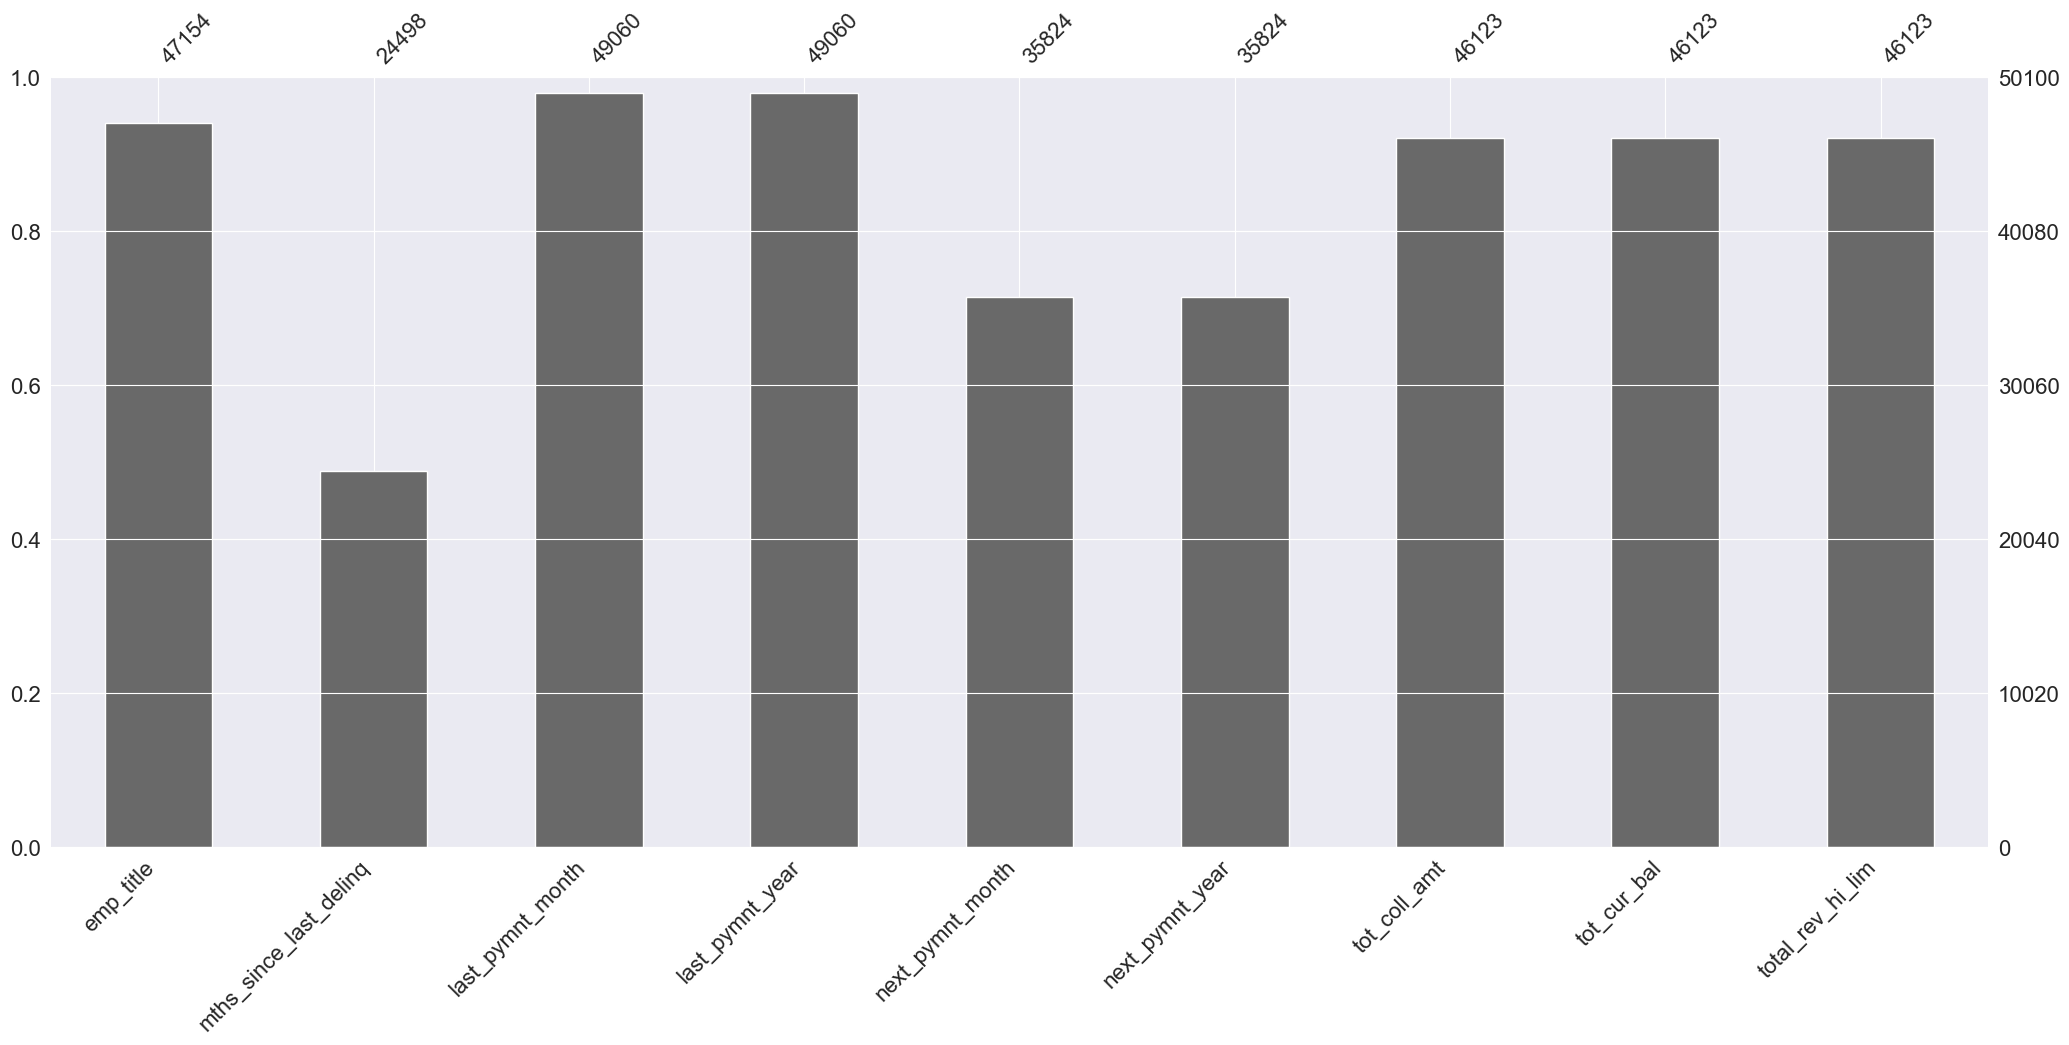

In [7]:
def plot_missing_data(df):
    """ plot Columns with Missing Values and Their Data Types
        Parameters:
        -----------
        df : pandas.DataFrame
        The input DataFrame to analyze for missing values. 
        Returns:
        --------
        None
    """
    threshold = int(df.shape[0]/100)# 1percent
    missing_counts = df.isnull().sum()
    df_missing = df[missing_counts[missing_counts > threshold].index.tolist()]
    msno.bar(df_missing)
    
plot_missing_data(df)

In the output above, we can see that **mths_since_last_delinq**, **next_pymnt_month** and **next_pymnt_year** have the highest percentage of missing values. This is likely due to the fact that information about these variables are not mandatory/available for all loaners, since for example not everyone has had a delinquencies on the lines of credit. However, many machine learning models have difficulties handling missing values, even if they are missing for a reason. As such we should impute meaningful values for these variables, that take into account, that we have no information for these case (e.g. we can impute the missing values in **mths_since_last_delinq** with *0*, as this would indicate that the borrower has not had a delinquency on the line of credit). We can do the same for **tot_cur_bal**, **tot_coll_amt**. Total revolving high credit (**total_rev_hi_lim**) is also missing for a large percentage of cases. This is likely due to the fact that not all borrowers have a revolving credit account. We can also impute these missing values with 0, as this would indicate that the borrower does not have a revolving credit account.

It would not be sensible to impute missing values for **next_pymnt_month**, **next_pymnt_year**, **last_pymnt_month**, **last_pymnt_year** with 0, as this would indicate that the next payment is due in 0 months. Furthermore, there is also no sensible way of imputing missing **emp_titles**.

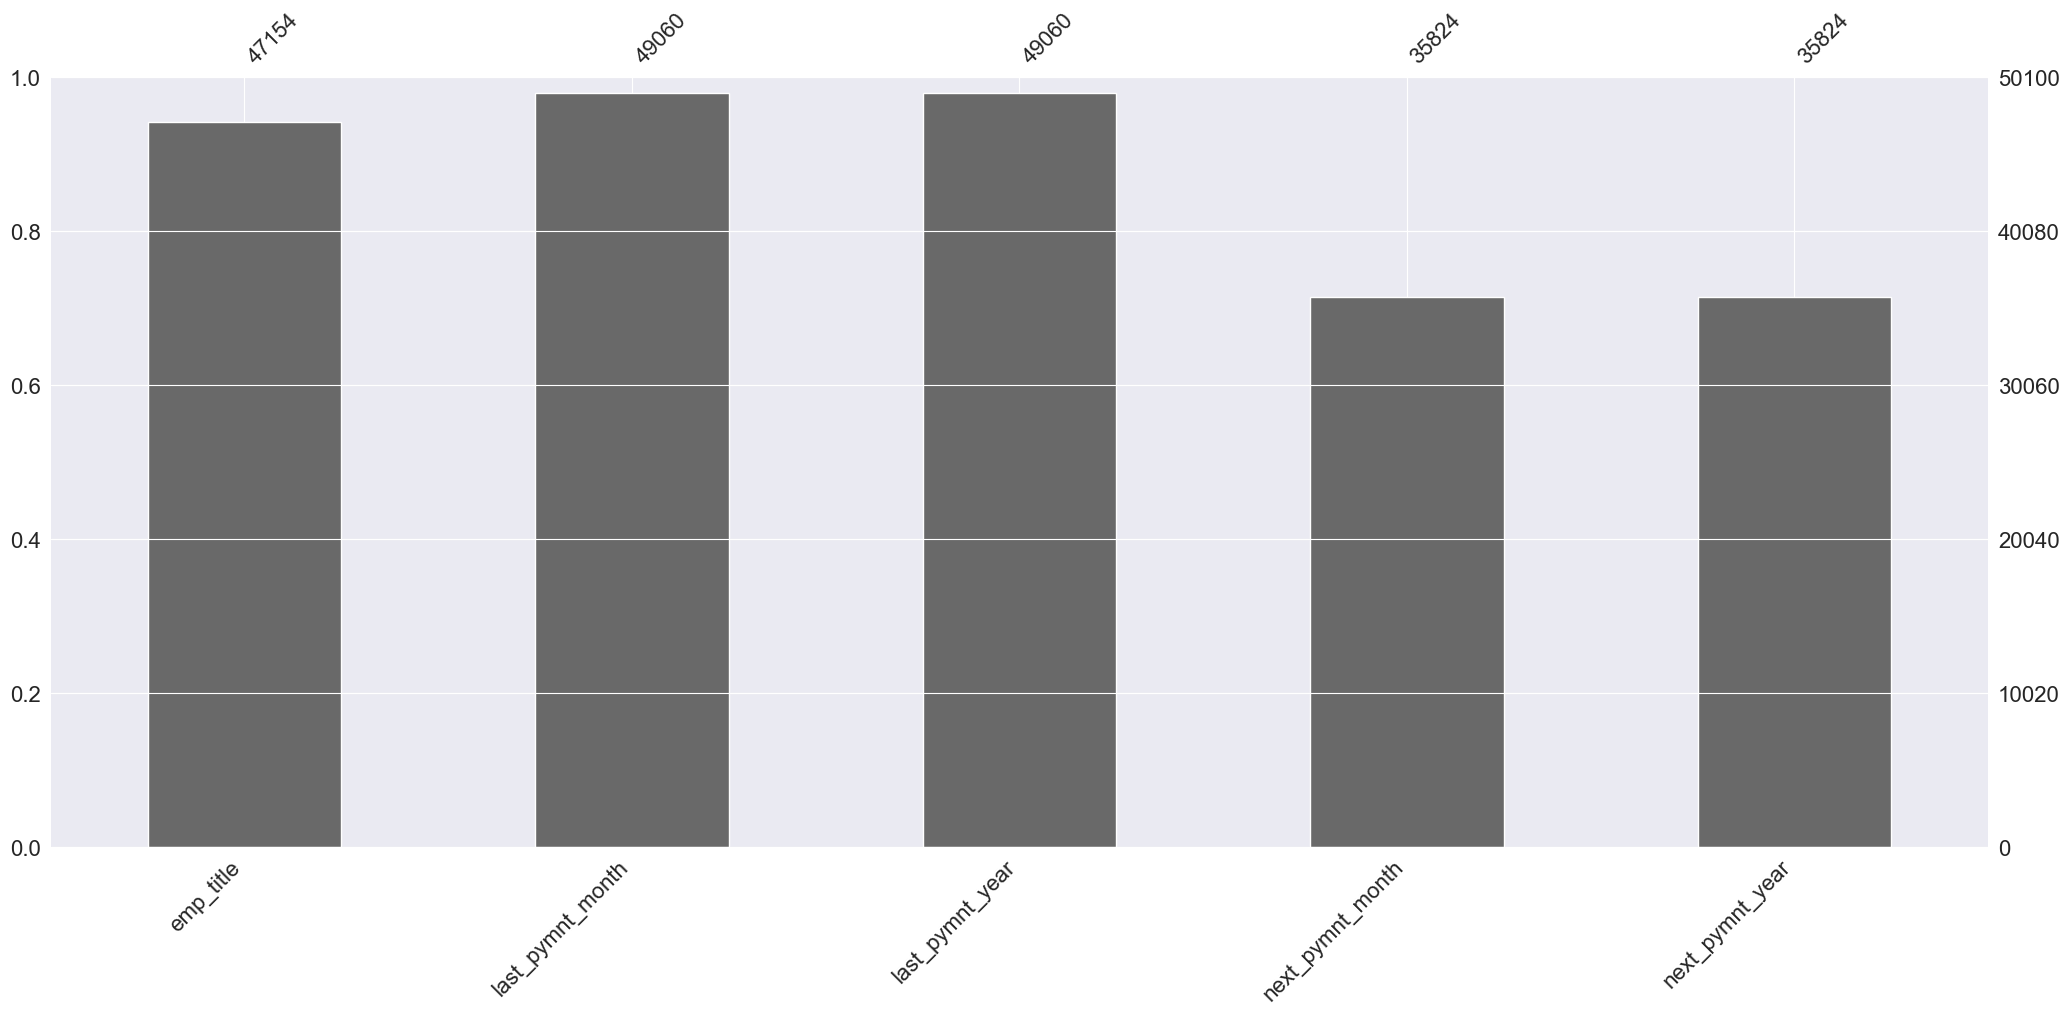

In [8]:
# impute missing values
df['mths_since_last_delinq'] = df['mths_since_last_delinq'].fillna(0)
df['tot_cur_bal'] = df['tot_cur_bal'].fillna(0)
df['tot_coll_amt'] = df['tot_coll_amt'].fillna(0)
df['total_rev_hi_lim'] = df['total_rev_hi_lim'].fillna(0)

# check if missing values have been imputed
plot_missing_data(df)

Overall, as a general rule we might want to always remove rows or columns with a high percentage of missing values (e.g. 95%), since these rows/columns are likely to posess very little information that can be used in analyses. In our dataset we do not have any cases that meet the 95% threshold.

In [9]:
# remove columns with more than 95% missing values
def find_columns_with_missing(df, threshold=1):
    """ Find Columns with all (or threshold) missing
        Parameters:
        -----------
        df : pandas.DataFrame
        The input DataFrame to analyze for missing values.
        Returns:
        --------
        List of Columns name
    """
    return [col for col in df.columns if df[col].isnull().sum() / df.shape[0] > threshold]


def remove_columns_with_missing(df, threshold=1):
    """ Remove Columns with all (or threshold) missing
        Parameters:
        -----------
        df : pandas.DataFrame
        The input DataFrame to analyze for missing values.
        Returns:
        --------
        pandas.DataFrame
    """
    cols_to_remove = find_columns_with_missing(df, threshold)
    return df.drop(columns=cols_to_remove), cols_to_remove

df, cols_to_remove = remove_columns_with_missing(df, 0.95)

# show columns that have been removed
cols_to_remove

[]

In [10]:
# remove rows with more than 95% missing values
def find_rows_with_missing(df, threshold=1):
    """ Find Rows with all (or threshold) missing
        Parameters:
        -----------
        df : pandas.DataFrame
        The input DataFrame to analyze for missing values.
        Returns:
        --------
        List of Rows index
    """
    return df.index[df.isnull().mean(axis=1) > threshold].tolist()

def remove_rows_with_missing(df, threshold=1):
    """ Remove Rows with all (or threshold) missing
        Parameters:
        -----------
        df : pandas.DataFrame
        The input DataFrame to analyze for missing values.
        Returns:
        --------
        pandas.DataFrame
    """
    rows_to_remove = find_rows_with_missing(df, threshold)
    return df.drop(index=rows_to_remove), rows_to_remove

df, rows_to_remove = remove_rows_with_missing(df, 0.95)

# show rows that have been removed
rows_to_remove

[]

# 1.2. Analyze Integrity
## 1.2.1. Duplicates
To identify duplicates the first step is to remove the first column, which simply contains a row index. If we do not remove this column, we will not be able to identify duplicated rows.

In [11]:
# drop first column
df = df.drop(columns='Unnamed: 0')

Looking at the output, the first obvious problem is that the ID variables (**id_pk**, **id_member**) do not seem to be unique. This might be due to duplicated entries in the dataset. We can check this by filtering for all entries containing duplicated 'member_id' and order by 'member_id'.

In [12]:
# filter for all entries containing duplicated 'member_id' order by member_id
df[df.duplicated(subset='member_id', keep=False)].sort_values(by='member_id')

,id_pk,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_year,last_credit_pull_month,last_credit_pull_year,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
50023,435307,520078,7000.0,7000.0,7000.000000,36,4.96,242.52,D,D2,...,NaN,Jul,2015.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0
23,435307,520078,7000.0,7000.0,7000.000000,36,4.96,242.52,D,D2,...,NaN,Jul,2015.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0
50011,526784,681457,11200.0,11200.0,11164.159885,36,3.23,378.62,C,C1,...,NaN,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0
11,526784,681457,11200.0,11200.0,11164.159885,36,3.23,378.62,C,C1,...,NaN,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0
50,558201,718601,7200.0,7200.0,7150.000000,60,7.56,181.12,E,E4,...,NaN,Feb,2015.0,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,67325141,72126853,28800.0,28800.0,28800.000000,60,0.64,621.03,B,B4,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,292439.0,36100.0
61,67367721,72179492,3000.0,3000.0,3000.000000,36,7.57,107.82,D,D4,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,101900.0,15300.0
50061,67367721,72179492,3000.0,3000.0,3000.000000,36,7.57,107.82,D,D4,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,101900.0,15300.0
50034,67828497,72687218,5000.0,5000.0,5000.000000,36,-4.68,150.58,A,A1,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,45434.0,59700.0


Additionally we can also check for rows where all variables are identical.

In [13]:
# show number of duplicates where all rows are equal
df.duplicated().sum()

95

Looking at the output we can see that we indeed have 95 duplicated cases (here the duplicates are identified by rows that contain identical values for all variables). However, we have 200 rows with duplicated member IDs (Here we identify duplicates based on members IDs only). This means that we have some cases where the member ID is duplicated, but the other variables are not identical. This is a problem, as it indicates that we have other inconsistencies in the data. Now let's start by removing the rows where all variables are identical.

In [14]:
# remove duplicates
df = df.drop_duplicates()
df.shape

(50005, 59)

Now we can re-check if we still have duplicates in the member_id variable. As we can see in the output below this is indeed the case. The mistake seems to lie in the variable **installment** where we have differing values for the same case. This is likely a data error, as the variable **installment** should contain the monthly payment owed by the borrower. This means that the value 50000 is likely a mistake, as it is unlikely that a borrower would have to pay 50'000 per month when the loan amount is less then 50'000. We should therefore remove duplicated cases where installment is higher than the loan amount.

In [15]:
# filter for all entries containing duplicated 'member_id' order by member_id and installment
df[df.duplicated(subset='member_id', keep=False)].sort_values(by=['member_id', 'installment'])

,id_pk,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_year,last_credit_pull_month,last_credit_pull_year,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
50004,4536779,5779043,16000.0,16000.0,15950.0,36,-1.10,508.06,A,A5,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,355820.0,45600.0
4,4536779,5779043,16000.0,16000.0,15950.0,36,-1.10,50000.00,A,A5,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,355820.0,45600.0
50002,18935279,21167968,20000.0,20000.0,20000.0,60,6.29,489.45,D,D2,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,35408.0,28300.0
2,18935279,21167968,20000.0,20000.0,20000.0,60,6.29,50000.00,D,D2,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,35408.0,28300.0
50003,27580978,30084088,15000.0,15000.0,15000.0,36,-3.97,456.54,A,A1,...,NaN,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,146372.0,81600.0
3,27580978,30084088,15000.0,15000.0,15000.0,36,-3.97,50000.00,A,A1,...,NaN,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,146372.0,81600.0
50000,55978502,59640239,14400.0,14400.0,14400.0,36,5.61,503.50,D,D1,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,15278.0,15000.0
0,55978502,59640239,14400.0,14400.0,14400.0,36,5.61,50000.00,D,D1,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,15278.0,15000.0
50001,56141977,59803813,24550.0,24550.0,24550.0,36,2.29,818.82,C,C1,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,163368.0,41400.0
1,56141977,59803813,24550.0,24550.0,24550.0,36,2.29,50000.00,C,C1,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,163368.0,41400.0


In [16]:
# remove duplicates with higher installment
df = df.drop_duplicates(subset='member_id', keep='last')

In [17]:
# show row for member id 5779043
df[df['member_id'] == 5779043]

,id_pk,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_year,last_credit_pull_month,last_credit_pull_year,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
50004,4536779,5779043,16000.0,16000.0,15950.0,36,-1.1,508.06,A,A5,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,355820.0,45600.0


## 1.2.2 Inconsistent Categories

### 1.2.2.1 Subgrade and Grade inconsistency
Another problem that becomes apparent when looking at the data is the discrepancy between the variables **grade** and **subgrade**. The **subgrade** variable is a subset of the **grade** variable. We can validate this by comparing the first letter in subgrade to the letter in grade.

In [18]:
# filter for rows where the first letter of subgrade does not match grade
df[df.apply(lambda x: x['sub_grade'][0] != x['grade'], axis=1)]

,id_pk,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_year,last_credit_pull_month,last_credit_pull_year,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
26,23943598,26316514,12000.0,12000.0,12000.0,36,0.99,392.81,B,ALPHA_CENTAURI,...,2016.0,Jan,2016.0,1.0,1.0,INDIVIDUAL,0.0,88.0,182767.0,23000.0
54,56052266,59714104,14000.0,14000.0,14000.0,60,-0.01,297.39,B,ALPHA_CENTAURI,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,169022.0,40200.0
79,63518237,67861038,10000.0,10000.0,10000.0,36,-0.01,322.63,B,ALPHA_CENTAURI,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,406066.0,15500.0
96,50655756,54035485,15400.0,15400.0,15400.0,36,-0.01,496.85,B,ALPHA_CENTAURI,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,43947.0,33200.0
102,48676289,51925085,21000.0,21000.0,21000.0,60,-0.01,446.09,B,ALPHA_CENTAURI,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,25175.0,30980.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49870,66380227,71104940,10000.0,10000.0,10000.0,36,-0.24,321.55,B,ALPHA_CENTAURI,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,292127.0,8500.0
49922,3370575,4223512,6400.0,6400.0,6400.0,36,2.12,212.94,B,ALPHA_CENTAURI,...,NaN,Jun,2015.0,0.0,1.0,INDIVIDUAL,0.0,0.0,50077.0,20694.0
49984,18294310,20447017,19500.0,19500.0,19500.0,60,0.99,423.89,B,ALPHA_CENTAURI,...,NaN,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,56624.0,67700.0
49987,60952305,64994090,12000.0,12000.0,12000.0,36,-0.01,387.15,B,ALPHA_CENTAURI,...,2016.0,Jan,2016.0,0.0,1.0,INDIVIDUAL,0.0,0.0,43481.0,43300.0


As seen in the output above, the **subgrade** variable contains the nonsensical value *ALPHA_CENTAURI*. We need to address this issue by removing this value. We can additionally create a validation that will remove any subgrade value that does not match the required format of Letter + Number.

In [19]:
# remove rows with nonsensical subgrade
df['sub_grade'] = df.apply(lambda row: row['sub_grade'] if row['sub_grade'] is not None and row['sub_grade'][0] in row['grade'] else None, axis=1)

# remove rows with subgrade that does not match the required format
df['sub_grade'] = df['sub_grade'].apply(lambda x: x if x is not None and x[0] in ['A', 'B', 'C', 'D', 'E', 'F', 'G'] and x[1].isdigit() else None)

# show unique values for grade and subgrade
(df['grade'].unique(), df['sub_grade'].unique())

(array(['D', 'B', 'A', 'E', 'C', 'F', 'G'], dtype=object),
 array(['D3', 'B5', 'D1', 'A5', 'A4', 'E1', 'C1', 'C4', 'E2', 'B2', 'C2',
        'E5', 'C3', 'D2', None, 'A2', 'C5', 'D5', 'D4', 'A1', 'E3', 'B1',
        'E4', 'B4', 'A3', 'F2', 'F4', 'F3', 'F1', 'G1', 'F5', 'G2', 'G3',
        'G4', 'G5'], dtype=object))

### 1.2.2.2 Interest Rate inconsistency
Another problem that becomes apparent when looking at the data is that the interest rate (**int_rate**) contains negative values. This is a mistake, as interest rates for loans should not be negative. We can check this by looking at the distribution of int_rate.

/Users/yanik/Library/Mobile Documents/com~apple~CloudDocs/Documents/Workshops and Courses/CAS_Data_Engineering/Kurs/Leistungsnachweise/Benotet/data_wrangling_testat/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='int_rate', ylabel='Count'>

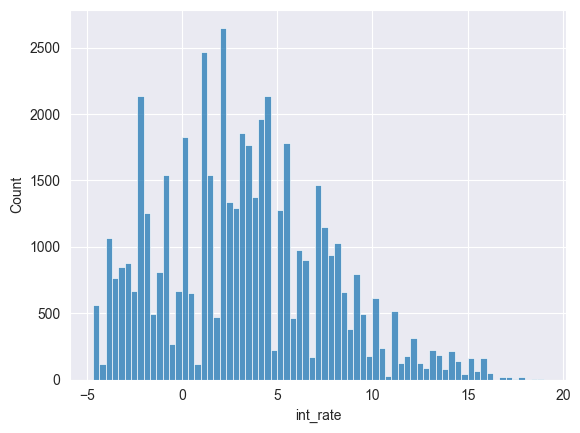

In [20]:
# show distribution of int_rate
sns.histplot(data=df, x='int_rate')

As the plot shows the distribution of **int_rate** encompasses negative values. It is difficult to determine if negative values in interest rate are created through an input error (e.g. instead of 5 the user inputed -5, such errors we would be able to correct by simply converting negative values to positive) or if the error is of another nature and the data is completely incorrect. As such, we err on the side of caution and remove all values for which **int_rate** is negative. We do not want to remove the complete row, since these might still contain valuable information for the other variables.

/Users/yanik/Library/Mobile Documents/com~apple~CloudDocs/Documents/Workshops and Courses/CAS_Data_Engineering/Kurs/Leistungsnachweise/Benotet/data_wrangling_testat/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='int_rate', ylabel='Count'>

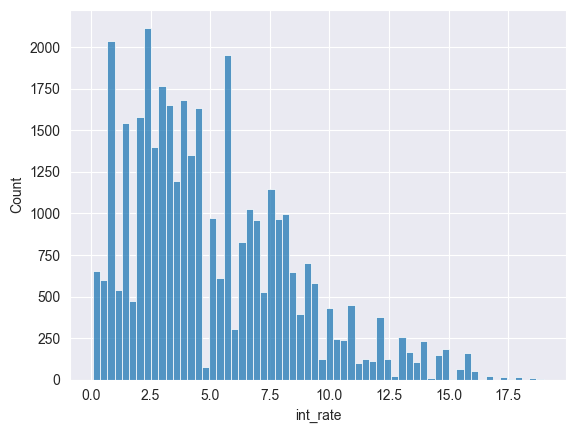

In [21]:
# replace negative values with NaN
df['int_rate'] = df['int_rate'].apply(lambda x: x if x > 0 else None)

# show distribution of int_rate
sns.histplot(data=df, x='int_rate')

# 1.3. Analyze Accuracy
## 1.3.1. Data Types and Formats
Another problem identified in the data are that at the moment dates are split into years and month. This becomes first visible when looking at the variables **issue_year** and **issue_month** as an example. Since we only have observations for 2015, this means that the **issue_year** variable by itself does not provide any useful information (no variation) in future analytical applications. Only in combination with the month, do we create variation in the data and thereby provide useful information.

<Axes: xlabel='issue_year', ylabel='count'>

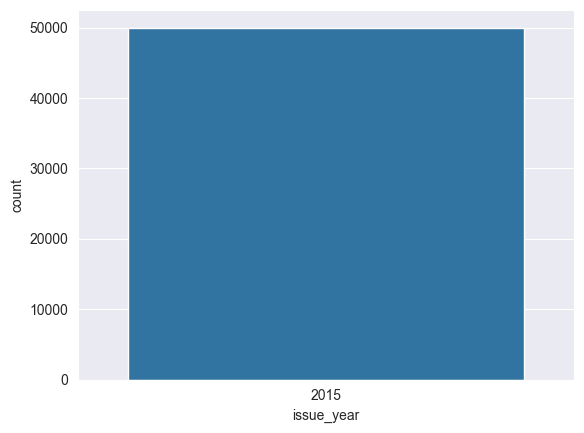

In [22]:
# show distribution of issue_year
sns.countplot(data=df, x='issue_year')

Contrary to **issue_year** the variable **issue_month** does show some variation, as shown in the plot below.

<Axes: xlabel='issue_month', ylabel='count'>

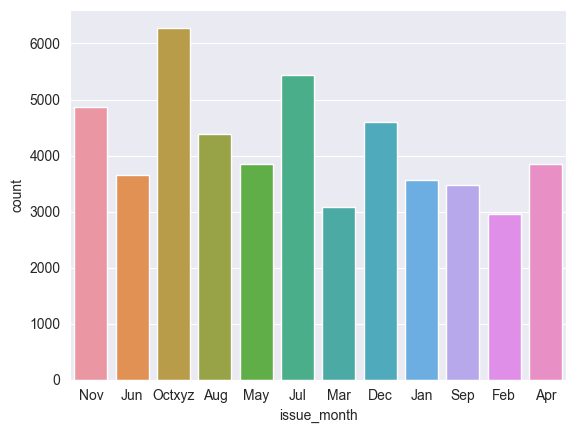

In [23]:
# show distribution of issue_month
sns.countplot(data=df, x='issue_month')

However, we also see that *October* was misspelled as *Octxyz*. We can fix this by replacing the misspelled value with the correct one.

In [24]:
# replace misspelled value
df['issue_month'] = df['issue_month'].replace('Octxyz', 'Oct')
df['issue_month'].unique()

array(['Nov', 'Jun', 'Oct', 'Aug', 'May', 'Jul', 'Mar', 'Dec', 'Jan',
       'Sep', 'Feb', 'Apr'], dtype=object)

To remedy the fact that issue_year contains no variation, but we still would like to know the year, we can create a new variable that combines the year and month into a single variable. This will allow us to keep the information about the year, but also the month. The same transformation can be applied to the other time variables in the dataset (earliest_cr_line_month, earliest_cr_line_year, last_pymnt_month, last_pymnt_year, next_pymnt_month, next_pymnt_year, last_credit_pull_month, last_credit_pull_year).

In [25]:
# create new variable issue_date with data type datetime
df['issue_date'] = pd.to_datetime(df['issue_year'].astype(str) + '-' + df['issue_month'], format='%Y-%b')

# drop issue_year and issue_month
df = df.drop(columns=['issue_year', 'issue_month'])

# show first 5 rows
df['issue_date'].head(5)

5   2015-11-01
6   2015-06-01
7   2015-10-01
8   2015-08-01
9   2015-05-01
Name: issue_date, dtype: datetime64[ns]

# 1.4. Text Issues
## 1.4.1. Text Harmonization
The **emp_title** variable contains 26'314 of different job titles. We can see this by looking at the number of unique values for **emp_title**.

In [26]:
df['emp_title'].nunique()

26314

Many of these job titles are likely to be the same, but are written in different ways. We can check this by looking at the unique values for **emp_title**.

In [27]:
# show unique values for emp_title and sort them
df['emp_title'].sort_values(ascending=False).unique()

array(['zueck transportation', 'zone manger', 'zone manager', ...,
       '  Credit rev specialist', '   Bus Operator and Instructor', nan],
      dtype=object)

As the example *zone manager* and *zone mager* shows, the difference in job titles might arise due to misspellings. Furthermore, we also have job titles like *youth specialist*, *youth services worker* or *youth development specialist* that are likely to be the same or very similar jobs, but that can be named differently. In order to try to reduce the cardinality of *emp_title* we can first convert all job titles to lower case and remove any leading or trailing white spaces.

In [28]:
# convert to lower case and remove leading and trailing white spaces
df['emp_title'] = df['emp_title'].str.lower().str.strip()

# count unique values
df['emp_title'].nunique()

23080

These two transformations alone managed to reduce the number of unique values by 3'234. Next we can try to further reduce the number of job titles by grouping together job titles that are similar. Looking at the top 20 job titles we can see for example already see that there are different variations of the manager job title. Furthermore, registered nurse and rn are likely to be the same job title.

In [29]:
def top20(df):
    print(df['emp_title'].groupby(df['emp_title']).size().reset_index(name='count')\
          .sort_values(by='count', ascending=False).head(20)
         )

top20(df)

                emp_title  count
20619             teacher    997
12111             manager    872
20201          supervisor    445
14438               owner    438
16674    registered nurse    429
17409               sales    388
6644               driver    360
17104                  rn    353
15918     project manager    275
14052      office manager    275
21503        truck driver    221
8613      general manager    219
15445           president    206
7143             engineer    180
22145      vice president    177
5988             director    175
17478       sales manager    174
15275      police officer    161
14231  operations manager    157
175       account manager    155


First we'll replace rn with registered nurse.

In [30]:
# replace rn with registered nurse
df['emp_title'] = df['emp_title'].replace('rn', 'registered nurse')

# show top 20 job titles
top20(df)

                emp_title  count
20618             teacher    997
12111             manager    872
16674    registered nurse    782
20200          supervisor    445
14438               owner    438
17408               sales    388
6644               driver    360
14052      office manager    275
15918     project manager    275
21502        truck driver    221
8613      general manager    219
15445           president    206
7143             engineer    180
22144      vice president    177
5988             director    175
17477       sales manager    174
15275      police officer    161
14231  operations manager    157
175       account manager    155
20025       store manager    147


Next we can try to group together job titles that are similar. In the output above we can identify many job titles that could be grouped into a larger category, such as teachers, managers, drivers, nurses, etc. We can do this by using the fuzzy match. The fuzzy match is a measure of similarity between two strings. The higher the score, the more similar the strings are. We set a threshold of 90, meaning that we only want to group together job titles that have a similarity score of 90 or higher.

In [31]:
def harmonise_with_threshold(col,cluster_string,threshold):
    for val, similarity in process.extract(cluster_string, df[col].unique(), limit = len(df[col].unique())):
        if similarity >= threshold:
            df.loc[df[col] == val, col] = cluster_string
            
# create list with cluster strings
cluster_list = ['manager', 'nurse', 'teacher', 'driver', 'assistant']

# harmonise job titles
for cluster_string in cluster_list:
    harmonise_with_threshold('emp_title', cluster_string, 90)

After grouping job titles via fuzzy match we can see that the number of unique job titles has been reduced to 20'507, thus we were able to reduce the number of unique job titles by 22%.

In [32]:
# show number of unique values for emp_title
df['emp_title'].nunique()

20507

# 1.5. Data Protection
We might want to encrypt some variables that contain sensitive information, such as the url. This is because the url might contain information that could be used to identify the borrower. In the case that we need to be able to convert the data back to its original form, we should use encryption. With encryption are able to use a key to encrypt and decrypt data.

In [33]:
# generate private key
private_key = Fernet.generate_key() # this key should be saved in config file

# create fernet object
fernet = Fernet(private_key)

# Ensure that 'url' column is of type string if not convert it
if isinstance(df['url'], str) is False:
    df['url'] = df['url'].astype(str)   

# encrypt url
df['url'] = df['url'].apply(lambda x: fernet.encrypt(x.encode()))
df[['member_id', 'url']].head(5)

,member_id,url
5,69697861,b'gAAAAABl6quArOzL-9lWEBpu-kyGocBmoJtWQ5r4P1T4...
6,949710,b'gAAAAABl6quAFVk60pZUIgvk2HeTZ9yrEsGpw1mtpNT7...
7,65632977,b'gAAAAABl6quAmo3ivyQD6vgI13dVI7Hm10Z05dlbMf-u...
8,60837944,b'gAAAAABl6quAb_64UtvjyPPNcbWyfQWOo2gfcbdXJXYv...
9,50629162,b'gAAAAABl6quAHOIvR89u8-PTSjdupkD-UwAFRjg3-ZvK...


In [34]:
# decrypt url
df['url'] = df['url'].apply(lambda x: fernet.decrypt(x).decode())
df[['member_id', 'url']].head(5)

,member_id,url
5,69697861,https://www.lendingclub.com/browse/loanDetail....
6,949710,https://www.lendingclub.com/browse/loanDetail....
7,65632977,https://www.lendingclub.com/browse/loanDetail....
8,60837944,https://www.lendingclub.com/browse/loanDetail....
9,50629162,https://www.lendingclub.com/browse/loanDetail....


If we have to permanently anonymize the data we can replace the url with a hash value.

In [35]:
# encrypt url
df['url'] = df['url'].apply(lambda x: hash(x))
df[['member_id', 'url']].head(5)

,member_id,url
5,69697861,1768013035759507930
6,949710,-8322724406366209749
7,65632977,7340820724891631113
8,60837944,7299394383004080510
9,50629162,-4246623276832971325
